In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
image_size = (256,256)
batch_size = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "PlantVillage",
            shuffle=True,
            image_size = image_size,
            batch_size= batch_size)

Found 16011 files belonging to 10 classes.


In [4]:
class_name = dataset.class_names
n_classes = len(class_name)

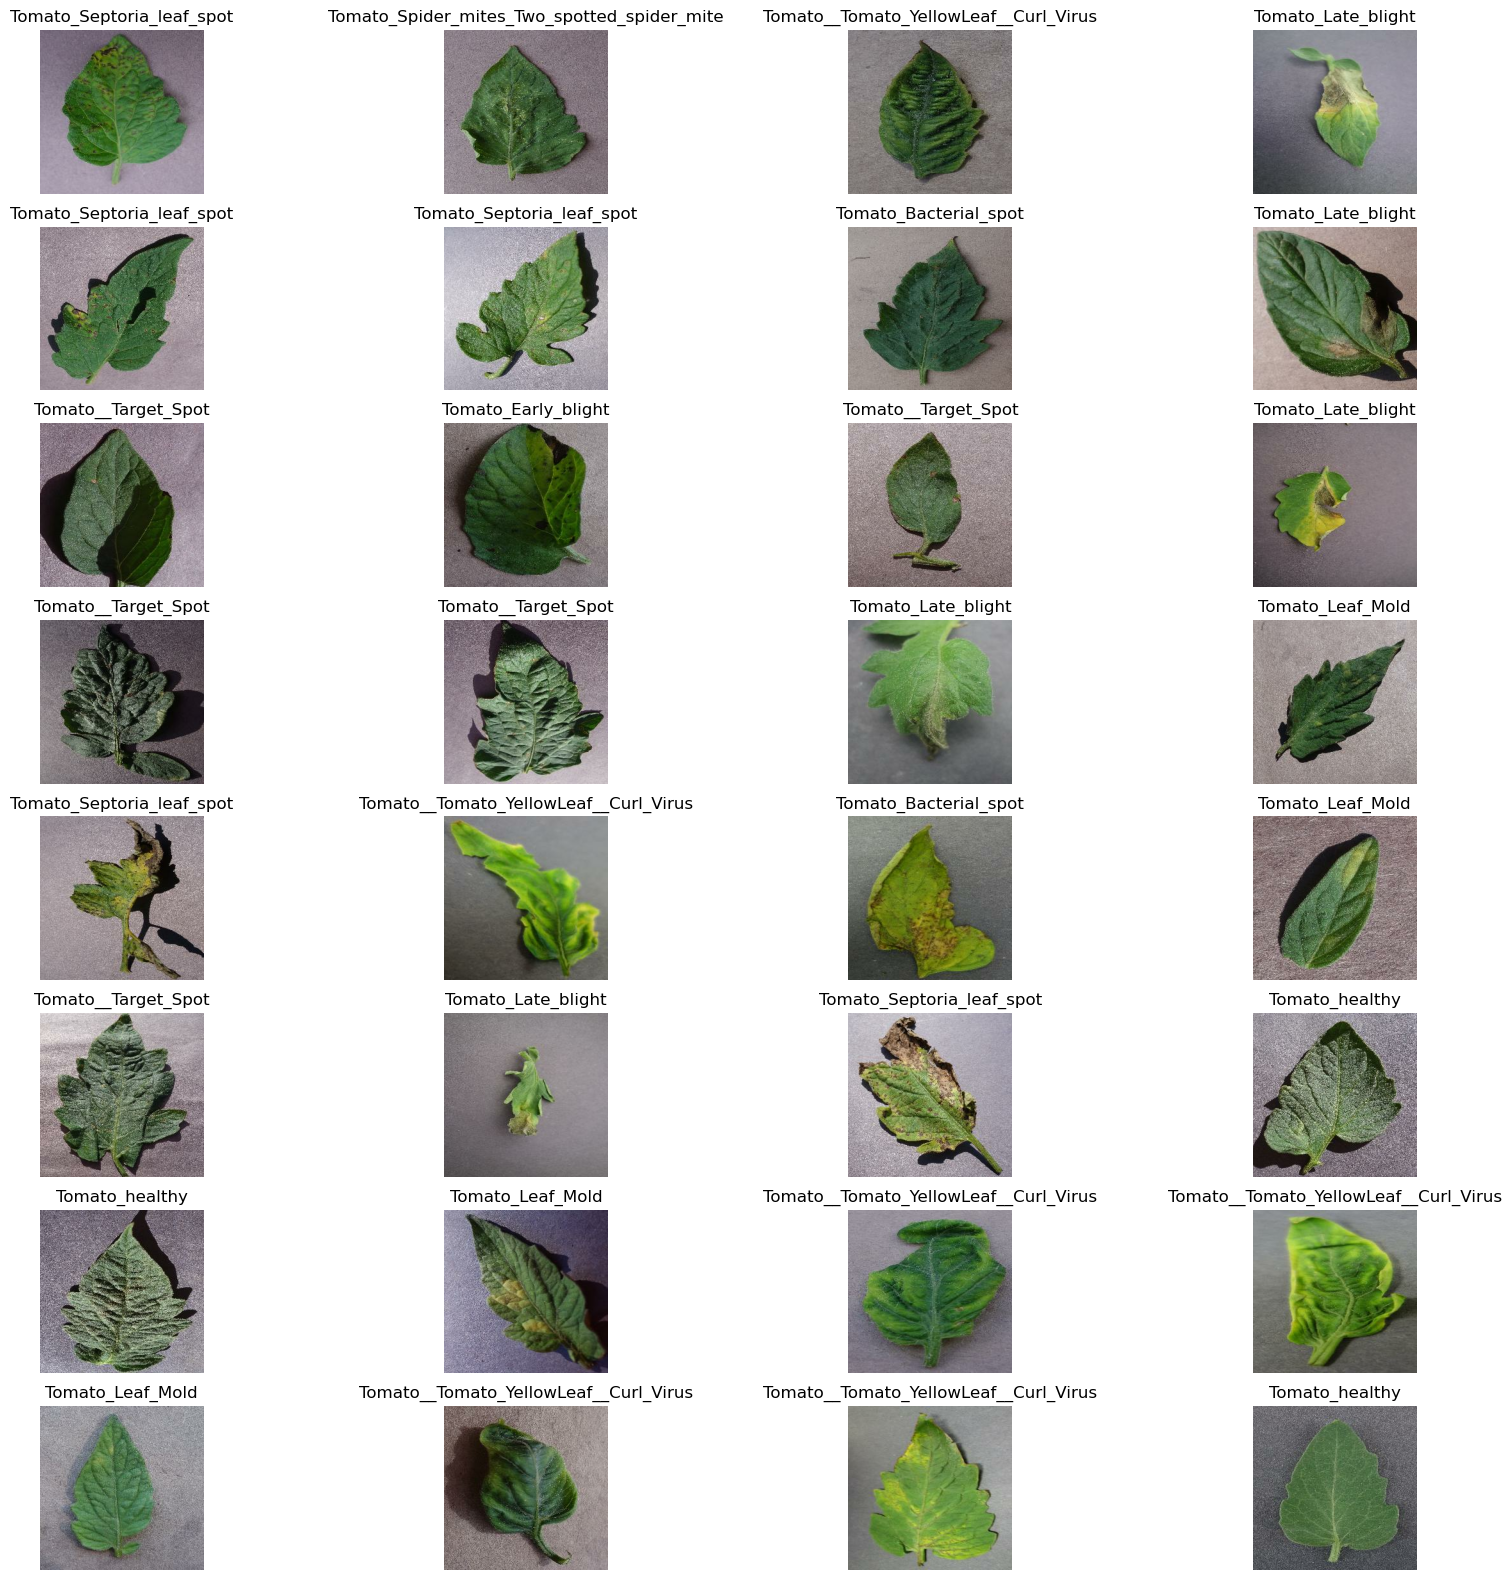

In [5]:
plt.figure(figsize=(20,20))

for image_batch, label_batch in dataset.take(1):
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_name[label_batch[i]])


### Train, Test split

In [6]:
def data_split(ds, train=0.8, valid = 0.1, test=0.1, shuffle=True, shuffle_size=1000):
    data_size =  len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(train*data_size)
    val_size = int(valid*data_size)
    test_size = data_size - (train_size + val_size)
    
    train_data = ds.take(train_size)
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data
    

In [7]:
train_data, val_data, test_data = data_split(ds=dataset)

In [8]:
train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size[0],image_size[1]),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
# Create a sequential model
model = models.Sequential()

model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 256, 256, 3)))  # Assuming 64x64 RGB images
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))  # Output layer with 10 classes

model.build(input_shape = (None,256,256,3))

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [14]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
model.fit(
    train_data,
    epochs=50,
    batch_size = None,validation_data = val_data,
    verbose = 2)

Epoch 1/50
400/400 - 613s - loss: 1.7690 - accuracy: 0.3528 - val_loss: 1.4226 - val_accuracy: 0.4938 - 613s/epoch - 2s/step
Epoch 2/50
400/400 - 568s - loss: 1.1162 - accuracy: 0.6016 - val_loss: 1.6828 - val_accuracy: 0.5000 - 568s/epoch - 1s/step
Epoch 3/50
400/400 - 570s - loss: 0.7808 - accuracy: 0.7256 - val_loss: 2.3310 - val_accuracy: 0.4894 - 570s/epoch - 1s/step
Epoch 4/50
400/400 - 566s - loss: 0.6106 - accuracy: 0.7830 - val_loss: 2.1215 - val_accuracy: 0.5337 - 566s/epoch - 1s/step
Epoch 5/50
400/400 - 567s - loss: 0.4845 - accuracy: 0.8268 - val_loss: 0.9508 - val_accuracy: 0.7331 - 567s/epoch - 1s/step
Epoch 6/50
400/400 - 566s - loss: 0.4127 - accuracy: 0.8608 - val_loss: 0.8221 - val_accuracy: 0.7150 - 566s/epoch - 1s/step
Epoch 7/50
400/400 - 564s - loss: 0.3626 - accuracy: 0.8734 - val_loss: 0.4397 - val_accuracy: 0.8338 - 564s/epoch - 1s/step
Epoch 8/50
400/400 - 565s - loss: 0.3302 - accuracy: 0.8809 - val_loss: 0.6247 - val_accuracy: 0.8025 - 565s/epoch - 1s/step


In [22]:
import numpy as np

1/1 [==============================] - 0s 28ms/step


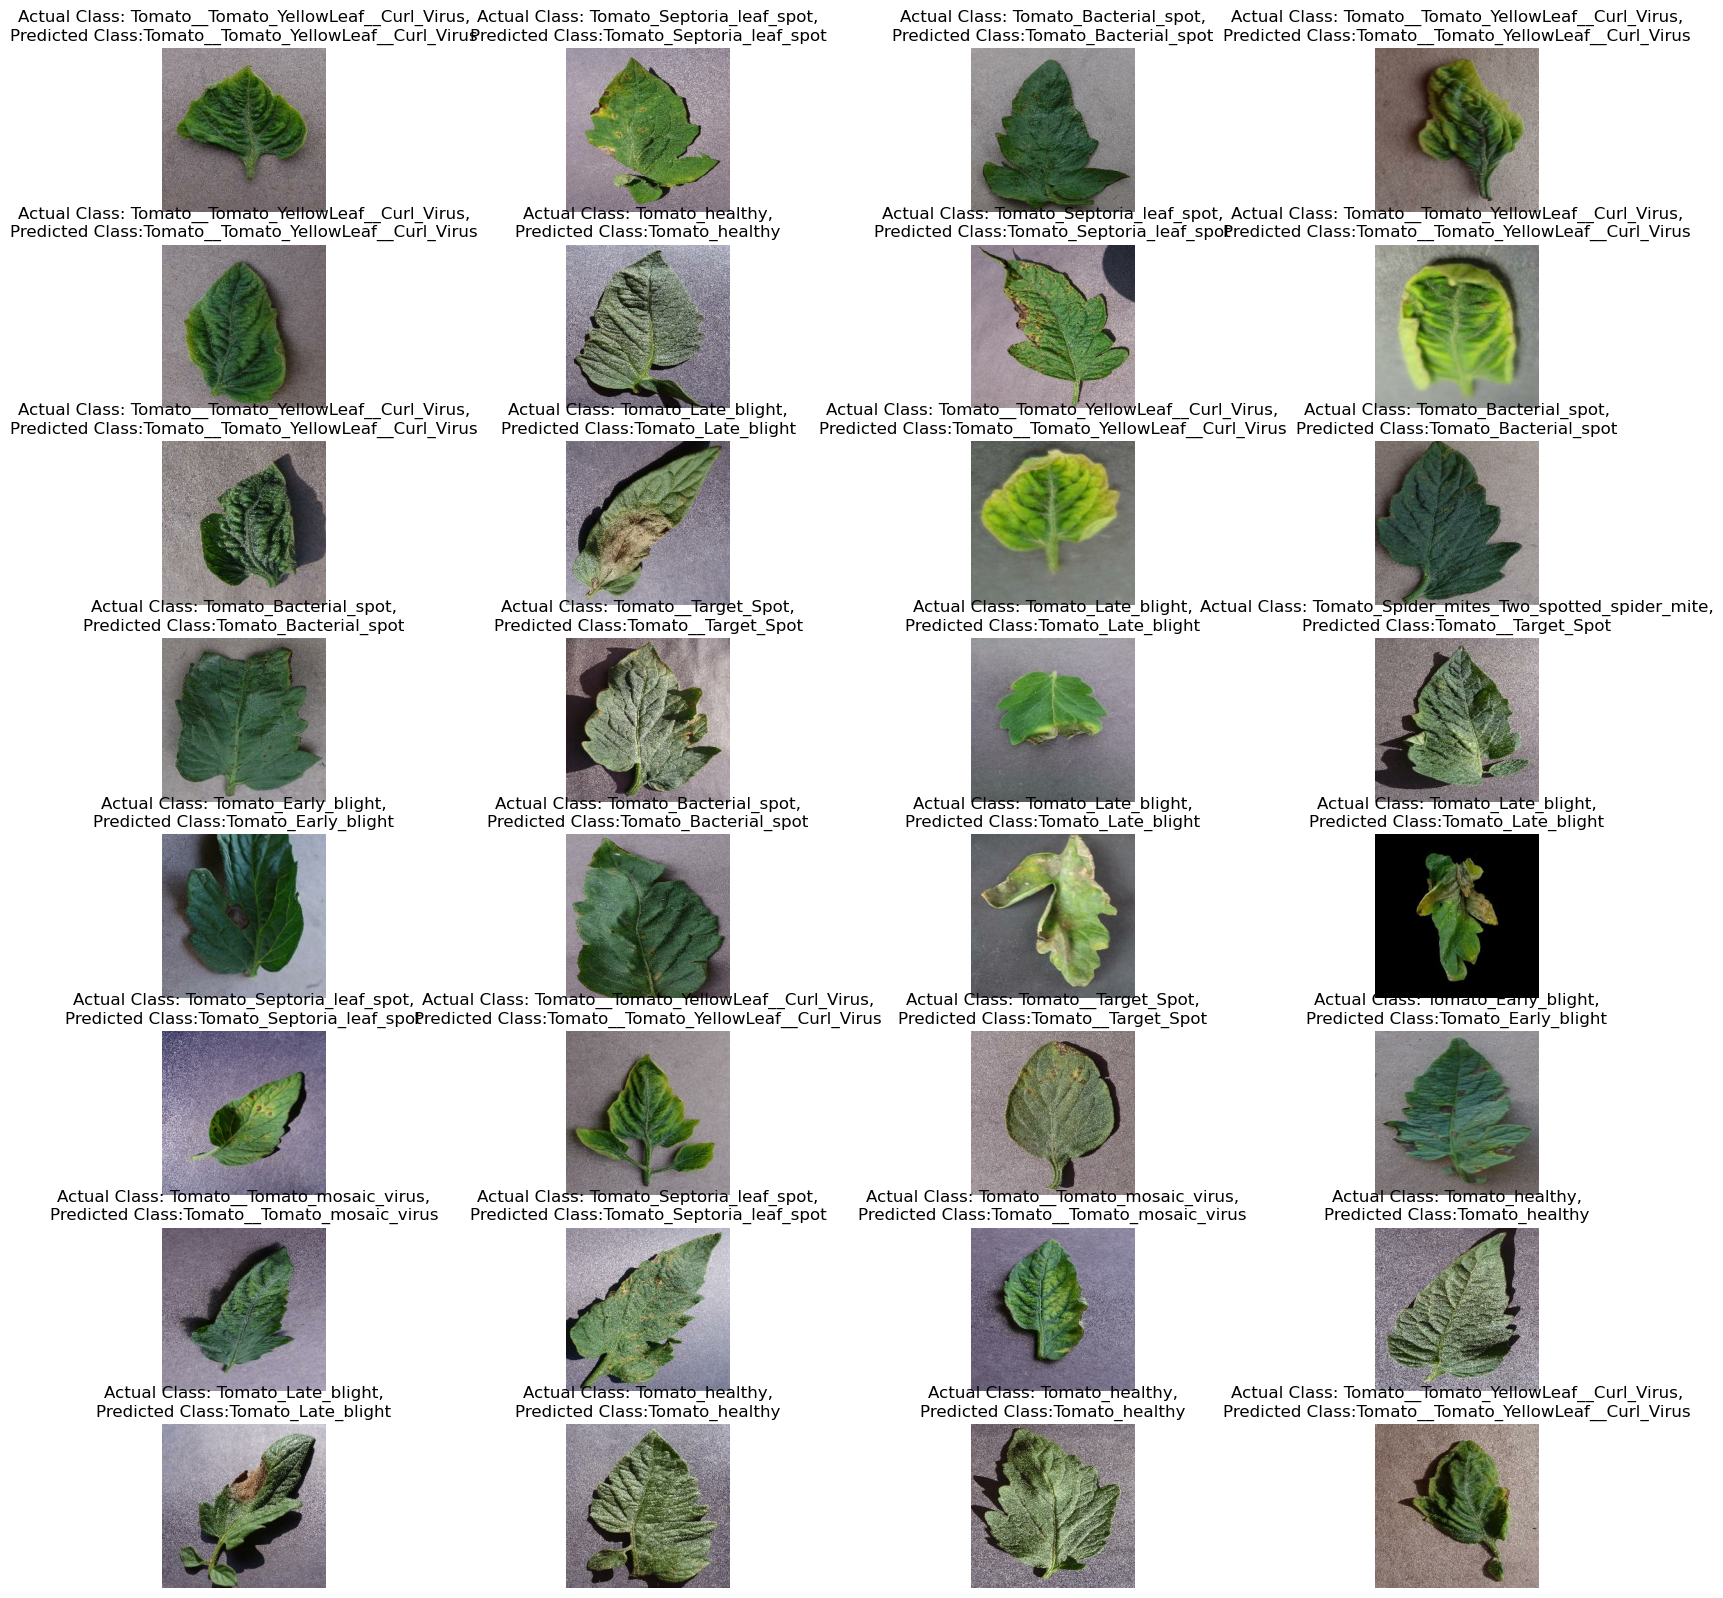

In [31]:
plt.figure(figsize=(20,20))

for image_batch, label_batch in test_data.take(1):
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predict = model.predict(np.expand_dims(image_batch[i].numpy(),axis=0))
        ind = np.argmax(predict)
        plt.axis('off')
        plt.title(f"Actual Class: {class_name[label_batch[i]]},\nPredicted Class:{class_name[ind]}")


## Storing the model for later use

In [100]:
import os
all_models = os.listdir("Models")

In [101]:
max(all_models)

'1'

In [96]:
model.save(r"Models\{0}".format(int(max(all_models))+1))

INFO:tensorflow:Assets written to: Models\5\assets


INFO:tensorflow:Assets written to: Models\5\assets
